In [1]:
import os
import librosa
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from keras import models, layers
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.utils import to_categorical


2025-04-04 13:15:34.042486: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-04 13:15:34.043128: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-04 13:15:34.046448: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-04 13:15:34.052885: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743752734.064908  103960 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743752734.06

In [2]:
# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)


In [3]:
def load_urban_sound_data(metadata_path, audio_path):
    metadata = pd.read_csv(metadata_path)
    
    # We'll classify emergency sounds (horn, siren) vs other sounds
    emergency_classes = ['car_horn', 'siren']
    metadata['emergency'] = metadata['class'].apply(lambda x: 1 if x in emergency_classes else 0)
    
    features = []
    labels = []
    
    for index, row in metadata.iterrows():
        file_path = os.path.join(audio_path, f"fold{row['fold']}", row['slice_file_name'])
        
        try:
            # Load audio file
            audio, sample_rate = librosa.load(file_path, res_type='kaiser_fast')
            
            # Extract MFCC features (you can add more features here)
            mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
            mfccs_scaled = np.mean(mfccs.T, axis=0)
            
            features.append(mfccs_scaled)
            labels.append(row['emergency'])
        except Exception as e:
            print(f"Error processing {file_path}: {e}")
            continue
    
    return np.array(features), np.array(labels)


In [4]:
metadata_path = '/home/karan/JupyterKaran/SoundClassifier/UrbanSound8K/metadata//UrbanSound8K.csv'  # Update this path
audio_path = '/home/karan/JupyterKaran/SoundClassifier/UrbanSound8K/audio'   # Update this path


In [5]:
X, y = load_urban_sound_data(metadata_path, audio_path)


/home/karan/JupyterKaran/SoundClassifier/envr/lib/python3.12/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1323
  warnings.warn(
/home/karan/JupyterKaran/SoundClassifier/envr/lib/python3.12/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1103
  warnings.warn(
/home/karan/JupyterKaran/SoundClassifier/envr/lib/python3.12/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1523
  warnings.warn(


In [6]:
# Encode labels
encoder = LabelEncoder()
y = to_categorical(encoder.fit_transform(y))


In [ ]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [8]:
# Add channel dimension for CNN
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)


In [9]:
def create_model(input_shape):
    model = models.Sequential()
    
    model.add(layers.Conv1D(64, 3, activation='relu', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling1D(2))
    
    model.add(layers.Conv1D(128, 3, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling1D(2))
    
    model.add(layers.Conv1D(256, 3, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling1D(2))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.5))
    
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Dense(y.shape[1], activation='softmax'))
    
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [10]:
input_shape = (X_train.shape[1], X_train.shape[2])
model = create_model(input_shape)


/home/karan/JupyterKaran/SoundClassifier/envr/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-04-04 13:37:49.111366: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [11]:
# Training

history = model.fit(X_train, y_train,
                    epochs=50,
                    batch_size=32,
                    validation_data=(X_test, y_test),
                    verbose=1)


Epoch 1/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8804 - loss: 0.3841 - val_accuracy: 0.9250 - val_loss: 0.1982
Epoch 2/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9392 - loss: 0.1687 - val_accuracy: 0.9588 - val_loss: 0.1113
Epoch 3/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9541 - loss: 0.1348 - val_accuracy: 0.9542 - val_loss: 0.1323
Epoch 4/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9630 - loss: 0.0997 - val_accuracy: 0.9599 - val_loss: 0.1040
Epoch 5/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9714 - loss: 0.0825 - val_accuracy: 0.9651 - val_loss: 0.0985
Epoch 6/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9765 - loss: 0.0754 - val_accuracy: 0.9571 - val_loss: 0.1175
Epoch 7/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9791 - loss: 0.0591 - val_accuracy: 0.9765 - val_loss: 0.0949
Epoch 8/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9791 - loss: 0.0576 - val_accuracy: 0.

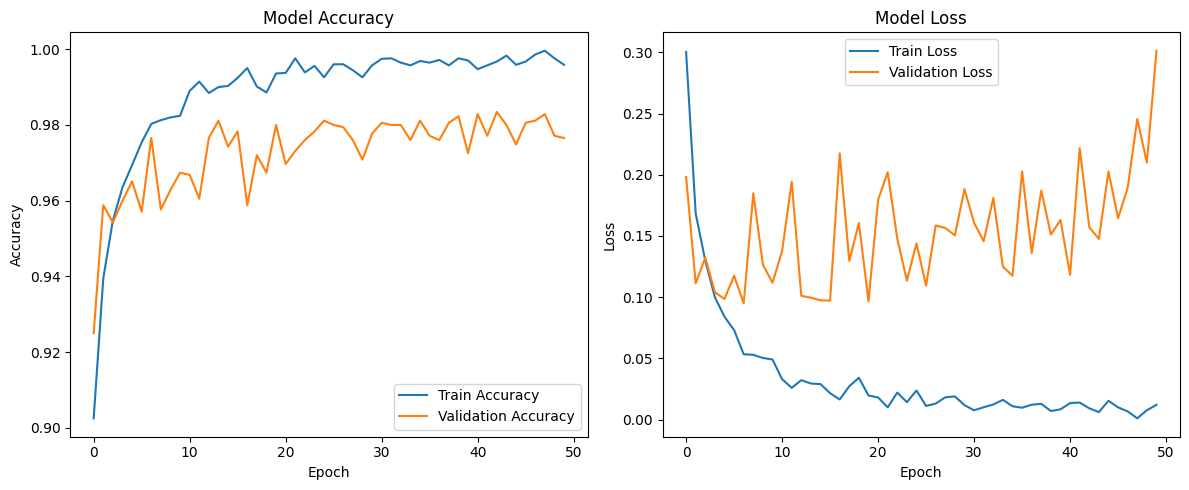

In [12]:
def plot_history(history):
    plt.figure(figsize=(12, 5))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

plot_history(history)

In [13]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f'\nTest accuracy: {test_acc:.4f}')


55/55 - 0s - 2ms/step - accuracy: 0.9765 - loss: 0.3013

Test accuracy: 0.9765


In [14]:
#Save the model
model.save('emergency_sound_classifier.h5')

In [1]:
from docx import Document
from docx.shared import Pt

# Create a new Word document
doc = Document()

# Add a title
doc.add_heading('Chronology of Events: Ashram Flyover Extension Project', level=1)

# Add a table with the chronology of events
data = [
    ['Date', 'Letter Number', 'Event Description'],
    ['09.07.2020', 'KCC/PWD/DND Flyover/20-21/18', 'Submission of traffic diversion plan for soil investigation work.'],
    ['16.07.2020', 'KCC/PWD/DND Flyover/20-21/22', 'Submission of Traffic Diversion Plan Phase-1 for widening of the existing road.'],
    ['05.09.2020', 'KCC/PWD/DND Flyover/20-21/48', 'Submission of revised Traffic Diversion Plan Phase-1, 2, and 3 after a review meeting with ACP/DCP.'],
    ['08.01.2021', 'Meeting', 'Meeting with Dy. Commissioner of Police-Traffic regarding approval of traffic diversion. Emphasis on removing encroachments for smooth traffic flow.'],
    ['09.01.2021', 'KCC/PWD/DND Flyover/20-21/114', 'Follow-up on the meeting regarding encroachment removal and submission of Phase-2 traffic plan for approval.'],
    ['22.03.2021', 'KCC/PWD/DND Flyover/20-21/154', 'Submission of Traffic Diversion Plan for Phase-2 Part (1) right side, after completing road widening and utility shifting.'],
    ['15.06.2021', 'KCC/PWD/DND Flyover/20-21/191', 'Report on delay in getting permission from Traffic Police Authority and request for expedited approval.'],
    ['23.07.2021', 'KCC/PWD/DND Flyover/20-21/210', 'Update on work progress after a joint survey and meeting with Asst. Commissioner of Police-Traffic.'],
    ['27.10.2022', 'KCC/PWD/DND Flyover/22-23/488', 'Submission of Traffic Diversion Plan Phase III for integrating existing flyovers with the new elevated structure.']
]

# Add table to the document
table = doc.add_table(rows=len(data), cols=3)
table.style = 'Table Grid'

# Add header and data rows
for i, row in enumerate(data):
    for j, cell_data in enumerate(row):
        table.cell(i, j).text = cell_data

# Save the document
doc.save('Chronology_of_Events_Ashram_Flyover.docx')


In [1]:
# Import necessary libraries
from docx import Document
from datetime import datetime

# Data from the previous chronology
previous_chronology = [
    ['09.07.2020', 'KCC/PWD/DND Flyover/20-21/18', 'Submission of traffic diversion plan for soil investigation work.'],
    ['16.07.2020', 'KCC/PWD/DND Flyover/20-21/22', 'Submission of Traffic Diversion Plan Phase-1 for widening of the existing road.'],
    ['05.09.2020', 'KCC/PWD/DND Flyover/20-21/48', 'Submission of revised Traffic Diversion Plan Phase-1, 2, and 3 after a review meeting with ACP/DCP.'],
    ['08.01.2021', 'Meeting', 'Meeting with Dy. Commissioner of Police-Traffic regarding approval of traffic diversion. Emphasis on removing encroachments for smooth traffic flow.'],
    ['09.01.2021', 'KCC/PWD/DND Flyover/20-21/114', 'Follow-up on the meeting regarding encroachment removal and submission of Phase-2 traffic plan for approval.'],
    ['22.03.2021', 'KCC/PWD/DND Flyover/20-21/154', 'Submission of Traffic Diversion Plan for Phase-2 Part (1) right side, after completing road widening and utility shifting.'],
    ['15.06.2021', 'KCC/PWD/DND Flyover/20-21/191', 'Report on delay in getting permission from Traffic Police Authority and request for expedited approval.'],
    ['23.07.2021', 'KCC/PWD/DND Flyover/20-21/210', 'Update on work progress after a joint survey and meeting with Asst. Commissioner of Police-Traffic.'],
    ['27.10.2022', 'KCC/PWD/DND Flyover/22-23/488', 'Submission of Traffic Diversion Plan Phase III for integrating existing flyovers with the new elevated structure.']
]

# Data from the PDF chronology
pdf_chronology = [
    ['21.06.2017', '-', 'UTTIPEC approved the project / scheme in its 54th Governing Body meeting chaired by Hon\'ble LG, Delhi.'],
    ['05.06.2020', '54(91)/PWD/F-31/267', 'Work awarded to M/s KCC Buildcon Pvt. Ltd.'],
    ['09.07.2020', '54(91)/PWD/F-31/366', 'Request to DCP (Traffic) for NOC for traffic diversion (09.07.2020 to 09.09.2020).'],
    ['17.07.2020', '54(91)/PWD/F-31/395', 'Follow-up from DCP (Traffic) regarding previous communication on diversion.'],
    ['28.08.2020', '-', 'Meeting in chamber of Addl. CP (Traffic) regarding road width and footpath.'],
    ['05.09.2020', 'KCC/PWD/DND Flyover/20-21/48', 'Agency\'s request for traffic diversion (Phase-1).'],
    ['14.09.2020', '54(91)/PWD/F-31/563', 'Compliance with traffic observations submitted.'],
    ['11.09.2020', '-', 'Meeting on "C/o Underpass at Ashram Chowk" also discussed this flyover extension.'],
    ['13.10.2020', '1031/SO/DCP/T-SR/NOC(Civil)/2020', 'DCP (Traffic) advised to apply phase-wise for NOC.'],
    ['17.10.2020', 'KCC/PWD/DND Flyover/20-21/62', 'Agency re-submitted Phase-1 Traffic Diversion Plan.'],
    ['18.12.2020', '54(91)/PWD/F-31/884', 'Internal communication reference by DCP (Traffic).'],
    ['14.01.2021', '54(91)/PWD/F-31/53', 'Status update reference.'],
    ['01.02.2021', '54(91)/PWD/F-31/126', 'Follow-up note on pending approvals.'],
    ['20.02.2021', '54(91)/PWD/F-31/213', 'Progress status update sent.'],
    ['06.03.2021', '54(91)/PWD/F-31/265', 'Additional note on project\'s urgency.'],
    ['19.05.2021', 'KCC/PWD/DND Flyover/20-21/177', 'KCC requested removal of obstructing red lights (DND loop, DND road, Maharani Bagh).'],
    ['20.05.2021', '54(91)/PWD/F-31/495', 'Reference to KCC\'s red light removal request.'],
    ['19.06.2021', '54(91)/PWD/F-31/584', 'Project coordination note.'],
    ['07.07.2021', '54(91)/PWD/F-31/630', 'Ongoing communication with traffic police.'],
    ['08.07.2021', '54(91)/PWD/F-31/635', 'Coordination for further implementation.'],
    ['28.07.2021', '54(91)/PWD/F-31/706', 'Project execution notes.'],
    ['09.08.2021', '54(91)/PWD/F-31/752', 'Communication raised to Special CP (Traffic).'],
    ['31.08.2021', '54(91)/PWD/F-31/818', 'Status of pending NOCs.'],
    ['10.09.2021', '54(91)/PWD/F-31/860', 'Additional concerns communicated.'],
    ['14.09.2021', '54(91)/PWD/F-31/876', 'Further escalation to Special CP (Traffic).'],
    ['06.10.2021', '54(91)/PWD/F-31/950', 'Follow-up letter issued.'],
    ['12.11.2021', '54(91)/PWD/F-31/1122', 'Noted correspondence.'],
    ['23.12.2021', '54(91)/PWD/F-31/1267', 'Reference to continued requirement of approval.'],
    ['28.12.2021', '54(91)/PWD/F-31/1280', 'Final follow-up before new year.'],
    ['17.02.2022', '54(91)/PWD/F-31/133', 'Final set of observations and suggestions issued by DCP.']
]

# Combine the two chronologies
combined_chronology = previous_chronology + pdf_chronology

# Sort the combined chronology by date
def sort_by_date(event):
    day, month, year = map(int, event[0].split('.'))
    return datetime(year, month, day)

combined_chronology.sort(key=sort_by_date)

# Add a header row
header = ['Date', 'Letter Number', 'Event Description']
combined_chronology.insert(0, header)

# Step 2: Create a Word Document with the Combined Chronology

# Create a new Word document
doc = Document()

# Add a title
doc.add_heading('Combined Chronology of Events: Ashram Flyover Extension Project', level=1)

# Add a table with the combined chronology
table = doc.add_table(rows=len(combined_chronology), cols=3)
table.style = 'Table Grid'

# Add header and data rows
for i, row in enumerate(combined_chronology):
    for j, cell_data in enumerate(row):
        table.cell(i, j).text = cell_data

# Save the document
doc.save('Combined_Chronology_Ashram_Flyover.docx')
